# LZ Limit setting - simple example
In this notebook we use https://arxiv.org/abs/2207.03764 and [`wimprates`](https://github.com/JelleAalbers/wimprates) to calculate no-background limits to compare to the LZ result

This notebook is just for educational purposes, the "real" thesis plots are made in the `limits.ipynb` notebook

In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wimprates
import os

import thesis_plots
from thesis_plots import mathrm
from thesis_plots.recoil_rates import nu, LimitSetter, LZ

# Make plots in preferred style using latex, but can safely be disabled
thesis_plots.setup_plt()
thesis_plots.print_versions(
    'thesis_plots wimprates'.split(),
    return_string=False,
    print_output=False,
    )

,module,version,path,git
0,python,3.10.4,/home/joran/yes/envs/py3.10/bin/python,None
1,thesis_plots,1.0.2,/home/joran/software/thesis_clean/thesis_plots,branch:master | 32f170d
2,wimprates,0.4.1,/home/joran/software/wimprates_clean/wimprates,branch:fix_hardcoded_v0 | 25c1317


In [2]:
lz_limit = pd.read_table(
    os.path.join(thesis_plots.root_folder, 'data', 'lz_limit', 'Fig5_SpinIndependentLimitandSensitivity.txt'),
    delimiter=' '
)

## The goal is tho replicate this plot from LZ:

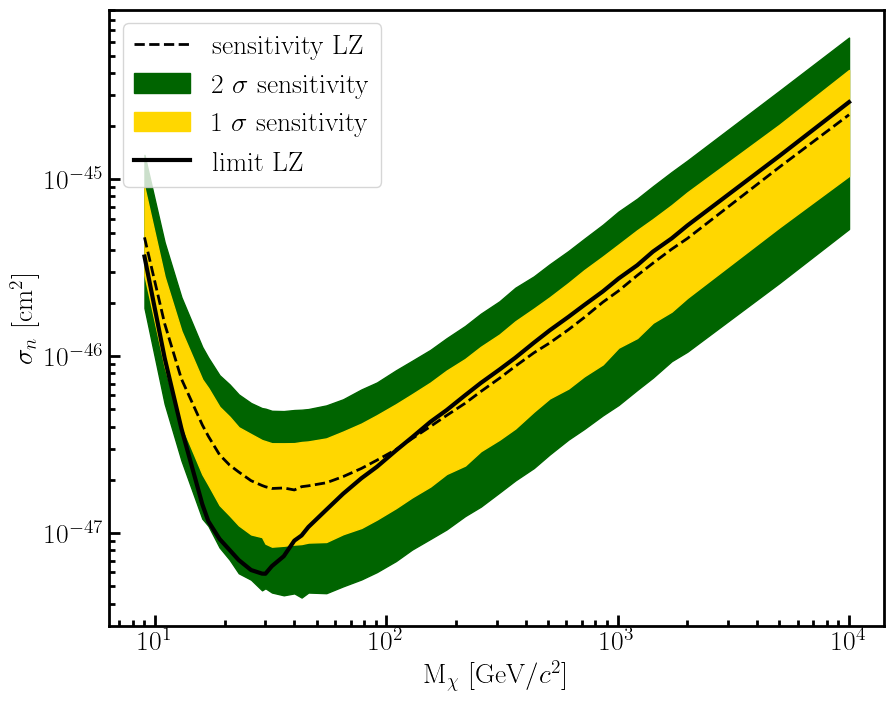

In [3]:
# LZ lines
kw = dict(marker='')
plt.ylabel('$\sigma_n\ [\mathrm{cm}^2]$')
plt.xlabel('$\mathrm{M}_\chi\ [\mathrm{GeV}/c^2]$')
plt.plot(lz_limit['mass(GeV)'], lz_limit['median'], label=mathrm('sensitivity LZ'),  ls='--',  c='k', **kw,)
plt.fill_between(lz_limit['mass(GeV)'], lz_limit['-2sigma'], lz_limit['+2sigma'], color='darkgreen',
                 label=mathrm('2 \\sigma sensitivity'))
plt.fill_between(lz_limit['mass(GeV)'], lz_limit['-1sigma'], lz_limit['+1sigma'], color='gold',
                 label=mathrm('1 \\sigma sensitivity'))
plt.plot(lz_limit['mass(GeV)'], lz_limit['limit(cm2)'], label=mathrm('limit LZ'),  ls='-', lw=3, c='k', **kw,)
plt.legend()
plt.yscale('log')
plt.xscale('log')

# Set limits
For this we need two things:
 - a detector with some exposure, detector response (efficiency x ROI)
 - a model of the expected wimp rates

In [4]:
detector = LZ()
benchmark_model = dict(v_0=238*nu.km/nu.s, 
                       v_esc=528*nu.km/nu.s, 
                       rho_dm=0.3* nu.GeV/nu.c0**2 / nu.cm**3)
halo_model = wimprates.StandardHaloModel(**benchmark_model)

In [5]:
limit_setter = LimitSetter(detector=detector, halo_model=halo_model)

Okay, how do we get a limit for each mass?

Answer: check where the 90% CL lies! We can use simple poisson statistics in this example. We will find this limit for each mass in the plot above

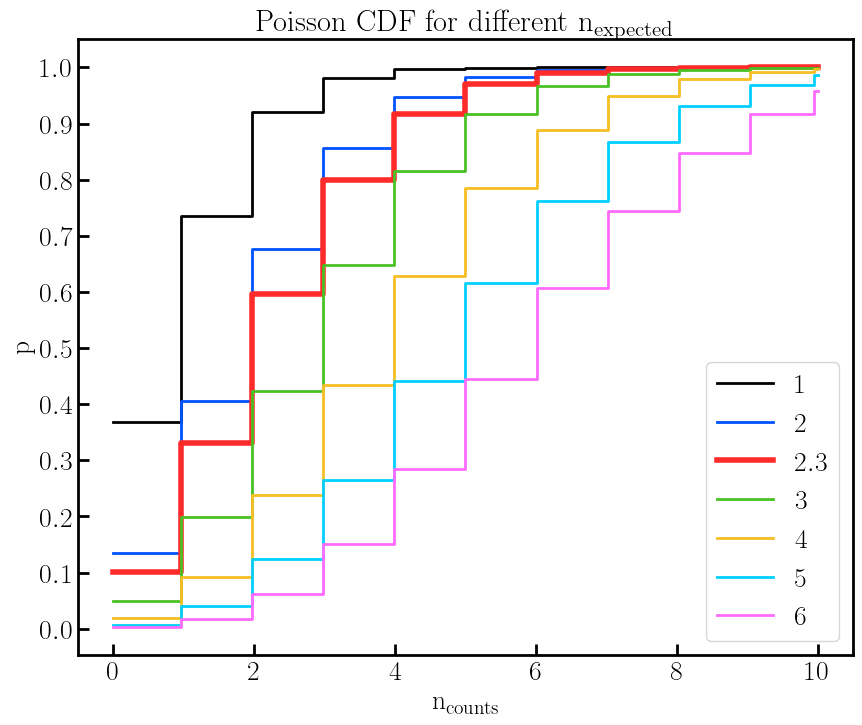

In [6]:
import scipy
x = np.linspace(0,10, 100)
for n_exp in [1, 2, 2.3, 3, 4, 5, 6]:
    
    plt.plot(x, scipy.stats.poisson.cdf(x, n_exp), marker='', label=f'${n_exp}$', 
             drawstyle='steps-mid',
            lw=4 if n_exp == 2.3 else 2)
plt.title(thesis_plots.mathrm('Poisson CDF for different n_{expected}'))
plt.yticks(np.arange(11)/10)
plt.ylabel(thesis_plots.mathrm('p'))
plt.xlabel(thesis_plots.mathrm('n_{counts}'))
plt.legend()

we need the acceptance of signal as function of recoil energy to account for things like the energy threshold

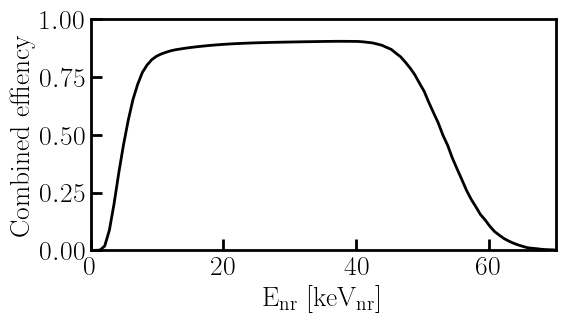

In [7]:
energy_kev = np.linspace(*detector.e_roi, 100)
plt.figure(figsize=(6,3))
plt.plot(energy_kev, detector.combined_efficiency(energy_kev), marker='')
plt.xlim(*detector.e_roi)
plt.ylim(0,1)
plt.xlabel(mathrm('E_{nr} [keV_{nr}]'))
plt.ylabel(mathrm('Combined effiency'))
thesis_plots.save_fig('LZ_combined_efficiency')

Lets take one example, what is the rate we get for the following wimp parameteres

/home/joran/software/wimprates_clean/wimprates/elastic_nr.py:73: RuntimeWarning: invalid value encountered in double_scalars
  return np.sin(x) / x**2 - np.cos(x) / x
/home/joran/software/wimprates_clean/wimprates/elastic_nr.py:73: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sin(x) / x**2 - np.cos(x) / x
/home/joran/software/wimprates_clean/wimprates/elastic_nr.py:226: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return halo_model.rho_dm / mw * (1 / mn(material)) * quad(


Text(0.5, 1.0, '$\\mathrm{50\\ GeV\\ WIMP\\ with\\ }$$\\sigma_n=10^{-47}$$\\mathrm{\\ Gev/c^2}$')

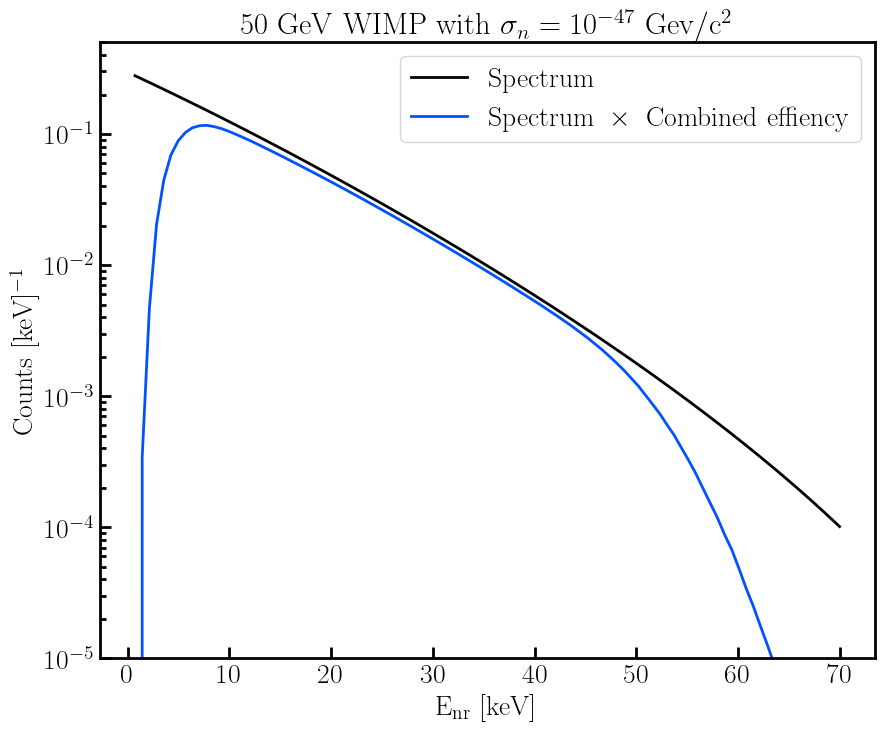

In [8]:
mw=50
log_cross_section=-47

e_nr = np.linspace(*detector.e_roi, 100)
rate = wimprates.rate_wimp(
                es=e_nr * 1000 * nu.eV,
                mw=mw * nu.GeV / nu.c0 ** 2,
                sigma_nucleon=10 ** log_cross_section * nu.cm ** 2,
                interaction='SI',
                material='Xe',
                halo_model=halo_model,
            ) * (nu.keV * (1000 * nu.kg) * nu.year) * detector.exposure
plt.plot(e_nr, rate, marker='', label=thesis_plots.mathrm('Spectrum'))
plt.plot(e_nr, rate * detector.combined_efficiency(e_nr), marker='', label=thesis_plots.mathrm('Spectrum \\times Combined effiency'))
plt.yscale('log')
plt.ylabel(thesis_plots.mathrm('Counts [keV]^{-1}'))
plt.xlabel(thesis_plots.mathrm('E_{nr} [keV]'))
plt.ylim(1e-5, 5e-1)
plt.legend()
plt.title(thesis_plots.mathrm(f'{mw} GeV WIMP with ') + f'$\sigma_n=10^{{{log_cross_section}}}$' + thesis_plots.mathrm(' Gev/c^2'))

In [9]:
# For this wimpmass, we get the following number of events:
print(f'For MW={mw} and sigma=10^{log_cross_section} we find '
      f'{limit_setter.integrate_rate(mw=mw, log_cross_section=log_cross_section):.2f} events')

For MW=50 and sigma=10^-47 we find 1.79 events


In [10]:
# Now, repleat to find for another cross-section a different number of events!
log_cross_section = np.log10(2*10**-47)
print(f'For MW={mw:.2f} and sigma=10^{log_cross_section:.2f} we find '
      f'{limit_setter.integrate_rate(mw=mw, log_cross_section=log_cross_section):.2f} events')

For MW=50.00 and sigma=10^-46.70 we find 3.58 events


To obtain the rates, we need some settings like which masses to compute. 

On github actions, we check that we can run this notebook, but that doesn't require spending a lot of time so we decrease our requirements then.


In [11]:
if os.environ.get('PLOT_FAST', False):
    mass_range = np.logspace(np.log10(5), np.log10(200), 5)
    limit_kw=dict(n_sigma_bins=5, log_sigma_range=(-48, -43))
else:
    # Normally, you run this, which takes about ~2.5 m/limit
    # If you want nice smooth plots, set n_sigma_bins to a large number, we use 
    # it to interpolate between to get the 90% conf. interval
    # n_masses dictates the number of mass-points to evaluate
    n_masses = 20
    n_sigma_bins = 20
    mass_range = np.logspace(np.log10(5), np.log10(1000), n_masses)
    limit_kw=dict(n_sigma_bins=n_sigma_bins, log_sigma_range=(-48, -44))

In [12]:
limit = limit_setter.set_limits(mass_range = mass_range, **limit_kw)

Getting limit for masses:   0%|          | 0/20 [00:00<?, ?it/s]

Load the LZ limit from their released data as reference

In [13]:
lz_limit = pd.read_table(
    os.path.join(thesis_plots.root_folder, 'data', 'lz_limit', 'Fig5_SpinIndependentLimitandSensitivity.txt'),
    delimiter=' '
)

Plot the limit!

Text(900, 0.93, 'Excludes more')

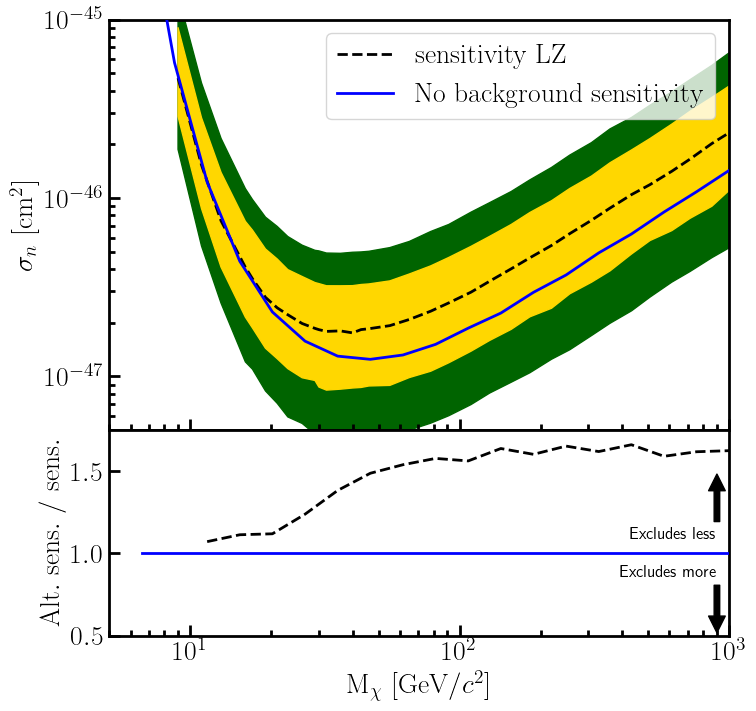

In [15]:
kw = dict(marker='')
_, axes = plt.subplots(
    2, 1, 
    sharex=True,
    figsize=(8,8),
    gridspec_kw={'height_ratios': [6, 3]})
plt.sca(axes[0])
# LZ lines
plt.plot(lz_limit['mass(GeV)'], lz_limit['median'], label=mathrm('sensitivity LZ'),  ls='--',  c='k', **kw,)
plt.fill_between(lz_limit['mass(GeV)'], lz_limit['-2sigma'], lz_limit['+2sigma'], color='darkgreen')
plt.fill_between(lz_limit['mass(GeV)'], lz_limit['-1sigma'], lz_limit['+1sigma'], color='gold')

# BG-free lines
plt.plot(mass_range, limit, label=mathrm('No background sensitivity'), **kw, zorder=3, c='b')

# Top panel settings
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$\sigma_n\ [\mathrm{cm}^2]$')
plt.legend(ncol=1, loc='upper right')
plt.ylim(5*10**-48, 10**-45)
# plt.ylim(10**-47, 3*10**-46)
plt.xlim(5, 1000)
plt.xscale('log')

# Bottom panel

plt.sca(axes[1])
# Skip the LZ sens
itp = scipy.interpolate.interp1d(lz_limit['mass(GeV)'], lz_limit['median'], bounds_error=False)
plt.plot(mass_range, itp(mass_range)/limit, **kw, c='k',ls='--')
plt.plot(mass_range, limit/limit, **kw, zorder=3, c='b')
# settings
plt.ylabel(mathrm('Alt. sens. / sens.'))
plt.xlabel('$\mathrm{M}_\chi\ [\mathrm{GeV}/c^2]$')
plt.subplots_adjust(hspace=0.)
# plt.ylim(.5, 1.75)
# plt.yticks([0.8, 1, 1.2, 1.4])
#Save
plt.ylim(0.5, 1.75)
text_x = 900
plt.annotate('Excludes less', 
             xy=(text_x, 1.5),  
             xycoords='data',
             xytext=(text_x, 1.07), 
             textcoords='data',
             fontsize=12,
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right', 
             verticalalignment='bottom',
            )
plt.annotate('Excludes more', 
             xy=(text_x, 0.5),  
             xycoords='data',
             xytext=(text_x, 0.93), 
             textcoords='data',
             fontsize=12,
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right', 
             verticalalignment='top',
            )